In [1]:
import os

os.environ["LEPHAREDIR"] = "/home/oilbert/LEPHARE"
os.environ["LEPHAREWORK"] = "/home/oilbert/LEPHARE/tests/WORK"

In [2]:
from lephare import *
import numpy as np
from matplotlib import pylab as plt

%matplotlib inline

In [3]:
keymap = read_config("../examples/COSMOS.para")

Number of keywords read in the config file: 93


In [4]:
keymap["ZPHOTLIB"] = keyword("ZPHOTLIB", "VISTA_COSMOS_FREE,ALLSTAR_COSMOS,QSO_COSMOS")
keymap["CAT_IN"] = keyword("CAT_IN", "$LEPHAREDIR/examples/COSMOS.in")
keymap["CAT_OUT"] = keyword("CAT_OUT", "zphot_short.out")
keymap["ADD_EMLINES"] = keyword("ADD_EMLINES", "0,100")
keymap["AUTO_ADAPT"] = keyword("ADD_EMLINES", "YES")
keymap["Z_STEP"] = keyword("Z_STEP", "0.04,0,6")
keymap["CAT_LINES"] = keyword("CAT_LINES", "1,100")
keymap["SPEC_OUT"] = keyword("SPEC_OUT", "YES")
keymap["PARA_OUT"] = keyword("PARA_OUT", "$LEPHAREDIR/examples/output.para")
keymap["VERBOSE"] = keyword("VERBOSE", "NO")
keymap["ZFIX"] = keyword("ZFIX", "YES")

In [5]:
photz = PhotoZ(keymap)

####################################### 
# PHOTOMETRIC REDSHIFT with OPTIONS   # 
# Config file            : 
# CAT_IN                 : /home/oilbert/LEPHARE/examples/COSMOS.in
# CAT_OUT                : zphot_short.out
# CAT_LINES              : 1 100
# PARA_OUT               : /home/oilbert/LEPHARE/examples/output.para
# INP_TYPE               : F
# CAT_FMT[0:MEME 1:MMEE] : 0
# CAT_MAG                : AB
# ZPHOTLIB               : VISTA_COSMOS_FREE ALLSTAR_COSMOS QSO_COSMOS 
# FIR_LIB                : 
# FIR_LMIN               : 7.000000
# FIR_CONT               : -1.000000
# FIR_SCALE              : -1.000000
# FIR_FREESCALE          : YES
# FIR_SUBSTELLAR         : NO
# ERR_SCALE              : 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.050000 0.050000 0.050000 0.050000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.050000 0.050000 0.050000 0.050000 0.100000 0.200000 0.300000 
# ERR_FACTOR       

In [6]:
filts = filterSvc.FilterSvc.from_config("../examples/COSMOS.para")

In [7]:
# for filt in filts:
#    plt.figure()
#    filt.plot_filter_curve()

In [8]:
# megacam_u = filterSvc.FilterSvc.from_svo(0,'CFHT/MegaCam.u')

In [9]:
# lephare_megacam_u = FilterSvc.from_file('../filt/cosmos/u_new.pb', 0, 1, 0)

In [10]:
# megacam_u.plot_filter_curve()
# filts[1].plot_filter_curve()

In [11]:
ztyp = keymap["ZGRID_TYPE"].split_int("", 1)[0]
dz, zmin, zmax = keymap["Z_STEP"].split_double("", 3)
gridz = zgrid(ztyp, dz, zmin, zmax)

H0, om0, lbd0 = keymap["COSMOLOGY"].split_double("", 3)
lcdm = cosmo(H0, om0, lbd0)

In [12]:
cat = np.loadtxt("../examples/COSMOS.in")
nfilt = 30
pos = 57
entry = cat[pos]
identifier = str(entry[0])
fluxes = entry[np.arange(1, nfilt * 2 + 1, 2)]
efluxes = entry[np.arange(1, nfilt * 2 + 1, 2) + 1]
context = int(entry[-3])
zspec = entry[-2]
additional_str = str(entry[-1])

In [13]:
src = onesource(0, gridz)
src.readsource(identifier, fluxes, efluxes, context, zspec, additional_str)

In [14]:
gbcont = keymap["GLB_CONTEXT"].split_int("", 1)[0]
contforb = keymap["FORB_CONTEXT"].split_int("", 1)[0]
# bdscal = keymap["BD_SCALE"].split_int("",1)[0]

src.fltUsed(gbcont, contforb, nfilt)
if False:  # this should be the test on cattype
    src.convertFlux("AB", filts)
src.convertMag()
min_err = keymap["ERR_SCALE"].split_double("0.0", -1)
fac_err = keymap["ERR_FACTOR"].split_double("1.0", -1)
src.errors(min_err, fac_err, nfilt)
src.keepOri()
src.closest_red = gridz[indexz(src.zs, gridz)]
zrange = [0, 0]
ebvrange = [0, 0]
mass_scale = [0, 0]
magabsB = [0, 0]
magabsF = [0, 0]
zrange[0] = ((keymap["Z_RANGE"]).split_double("0", 2))[0]
zrange[1] = ((keymap["Z_RANGE"]).split_double("1000", 2))[1]
ebvrange[0] = ((keymap["EBV_RANGE"]).split_double("0", 2))[0]
ebvrange[1] = ((keymap["EBV_RANGE"]).split_double("1000", 2))[1]
# mass_scale[0]  =((keymap["MASS_SCALE"]).split_double("0.",2))[0];
# mass_scale[1]  =((keymap["MASS_SCALE"]).split_double("0.",2))[1];
magabsB[0] = ((keymap["MAG_ABS"]).split_double("0.", 2))[0]
magabsF[0] = ((keymap["MAG_ABS"]).split_double("0.", 2))[1]
if magabsB[0] > magabsF[0]:
    inter = magabsF[0]
    magabsF[0] = magabsB[0]
    magabsB[0] = inter

magabsB[1] = ((keymap["MAG_ABS_QSO"]).split_double("0.", 2))[0]
magabsF[1] = ((keymap["MAG_ABS_QSO"]).split_double("0.", 2))[1]
if magabsB[1] > magabsF[1]:
    inter = magabsF[1]
    magabsF[1] = magabsB[1]
    magabsB[1] = inter

src.setPriors(magabsB, magabsF)

In [15]:
zfix = False
lmasi = 0.0
lmass = 0.0
magabsB = [-24.0, -30.0]
magabsF = [-5.0, -10.0]
funz0 = lcdm.distMod(gridz[1] / 20.0)
bp = [-2, -2]

In [16]:
valid = src.validLib(photz.fullLib, zfix, src.zs)

In [17]:
src.fit(photz.fullLib, photz.flux, valid, funz0, bp)

In [18]:
src.rm_discrepant(photz.fullLib, photz.flux, valid, funz0, bp, 500.0, True)

In [19]:
src.spec, src.indmin, src.consiz

('58.0', [147792, 4840, 8523], 0.0)

In [21]:
src.generatePDF(photz.fullLib, valid, [32, 4, 4, 13], -1, zfix)
src.interp(zfix, True, lcdm)

In [22]:
src.uncertaintiesMin()
src.uncertaintiesBay()
src.secondpeak(photz.fullLib, 0.3, 0.02)
src.considered_red(zfix, "BEST")
src.interp_lib(photz.fullLib, nfilt, lcdm)

In [23]:
method = keymap["MABS_METHOD"].split_int("0", -1)[0]
magabscont = keymap["MABS_CONTEXT"].split_long("0", -1)
bapp = np.asarray(keymap["MABS_REF"].split_int("1", -1)) - 1
bappOp = np.asarray(keymap["MABS_FILT"].split_int("1", -1)) - 1
nbBinZ = len(bappOp)
zbmin = keymap["MABS_ZBIN"].split_double("0", nbBinZ + 1)
zbmax = keymap["MABS_ZBIN"].split_double("6", nbBinZ + 1)
zbmin = zbmin[:-1]
zbmax = zbmin[1:]
goodFlt = bestFilter(nfilt, gridz, photz.fullLib, method, magabscont, bapp, bappOp, zbmin, zbmax)
maxkcol = maxkcolor(gridz, photz.fullLib, goodFlt)

src.absmag(goodFlt, maxkcol, lcdm, gridz)

In [24]:
limits_zbin = keymap["LIMITS_ZBIN"].split_double("0.0,90.", -1)
nzbin = len(limits_zbin) - 1
limits_ref = keymap["LIMITS_MAPP_REF"].split_int("1", 1)[0]
limits_sel = keymap["LIMITS_MAPP_SEL"].split_int("1", nzbin)
limits_cut = keymap["LIMITS_MAPP_CUT"].split_double("90.", nzbin)
src.limits(photz.fullLib, limits_zbin, limits_ref, limits_sel, limits_cut)

In [25]:
opaOut = GalMag.read_opa()
src.computeEmFlux(photz.fullLib, lcdm, opaOut)

In [26]:
# %load_ext autoreload
# %autoreload 2
# import lephare
# from lephare import *
minl = 1.0e10
maxl = 0
for f in filts:
    if minl > f.lmean - 2 * f.dwidth:
        minl = f.lmean - 2 * f.dwidth
    if maxl < f.lmean + 2 * f.dwidth:
        maxl = f.lmean + 2 * f.dwidth

In [27]:
gal1 = src.best_spec_vec(0, photz.fullLib, lcdm, opaOut, minl, maxl)
gal2 = src.best_spec_vec(1, photz.fullLib, lcdm, opaOut, minl, maxl)
fir = src.best_spec_vec(2, photz.fullLibIR, lcdm, opaOut, minl, maxl)
qso = src.best_spec_vec(3, photz.fullLib, lcdm, opaOut, minl, maxl)
star = src.best_spec_vec(4, photz.fullLib, lcdm, opaOut, minl, maxl)

In [28]:
models_info = []  # à remplir
if src.indmin[0] >= 0:
    models_info.append(
        [
            "GAL-1",
            len(gal1[0]),
            str(src.imasmin[0]),
            "1",
            str(src.nbused),
            str(src.consiz),
            src.zgmin[1],
            src.zgmin[2],
            src.chimin[0],
            "-1",
            photz.fullLib[src.indmin[0]].extlawId,
            photz.fullLib[src.indmin[0]].ebv,
            src.Ldustmed[0],
            src.agemed[0],
            src.massmed[0],
            src.SFRmed[0],
            src.sSFRmed[0],
        ]
    )
else:
    models_info.append(["GAL-1 0 -1 -1 -1 -1. -1. -1. -1. -1. -1 -1. -1. -1. -1. -1. -1.".split()])

# second solution
if src.indminSec >= 0:
    models_info.append(
        [
            "GAL-2",
            len(gal2[0]),
            str(src.zsecMod),
            "1",
            str(src.nbused),
            src.zsec,
            "-1",
            "-1",
            src.zsecChi2,
            src.zsecProb,
        ]
        + "-1 -1. -1. -1. -1. -1. -1.".split()
    )
else:
    models_info.append("GAL-2 0 -1 -1 -1 -1. -1. -1. -1. -1. -1 -1. -1. -1. -1. -1. -1.".split())

# Galaxy FIR
if src.indminIR >= 0:
    models_info.append(
        [
            "GAL-FIR",
            len(fir[0]),
            imasminIR,
            "1",
            src.nbused,
            src.zminIR,
            "-1 -1".split(),
            src.chiminIR,
            "0 -1 -1".split(),
            src.LIRml,
        ]
        + "-1 -1 -1 -1".split()
    )
else:
    models_info.append("GAL-FIR 0 -1 -1 -1 -1. -1. -1. -1. -1. -1 -1. -1. -1. -1. -1. -1.".split())

## STOCH
##models_info.append("GAL-STOCH 0 -1 -1 -1 -1. -1. -1. -1. -1. -1 -1. -1. -1. -1. -1. -1.".split())

# QSO
if src.zmin[1] > 0:
    models_info.append(
        [
            "QSO",
            len(qso[0]),
            str(src.imasmin[1]),
            "2",
            str(src.nbused),
            str(src.zmin[1]),
            "0",
            "0",
            src.chimin[1],
        ]
        + "0. -1 -1. -1. -1. -1. -1. -1.".split()
    )

else:
    models_info.append("QSO 0 -1 -1 -1 -1. -1. -1. -1. -1. -1 -1. -1. -1. -1. -1. -1.".split())

# STAR
if src.chimin[2] > 0:
    models_info.append(
        ["STAR", len(star[0]), str(src.imasmin[2]), "3", str(src.nbused), "0", "0", "0", src.chimin[2]]
        + "0. -1 -1. -1. -1. -1. -1. -1.".split()
    )
else:
    models_info.append("STAR 0 -1 -1 -1 -1. -1. -1. -1. -1. -1 -1. -1. -1. -1. -1. -1.".split())

In [29]:
id = src.spec
zspec = str(src.zs)
zphot = src.consiz
nfilt = len(filts)
npdf = src.pdfmap[maptype["MIN_ZG"]].size()
mag = np.array(src.mab)
em = np.array(src.msab)
lf = np.array([f.lmean * 10000 for f in filts])
dlf = np.array([f.dwidth * 10000 for f in filts])
zpdf = np.zeros((3, npdf))
zpdf[0, :] = src.pdfmap[maptype["BAY_ZG"]].xaxis
zpdf[1, :] = src.pdfmap[maptype["BAY_ZG"]].vPDF
zpdf[2, :] = src.pdfmap[maptype["MIN_ZG"]].vPDF
lg = []
mg = []
for sol in [gal1, gal2, fir, qso, star]:
    lg.append(np.array(sol[0]))
    mg.append(-0.4 * (np.array(sol[1]) - 23.91))  # logFnu

In [30]:
filts[15].dwidth

242.071742512102

[1.12388592e-02 7.77853017e-03 1.39032683e-02 9.52921883e-03
 7.89208635e-03 8.94837594e-03 1.04938188e-02 8.41567695e-03
 8.39705407e-03 1.11834102e-02 1.44291744e-02 3.14066371e-02
 4.68799473e-02 1.94906644e-02 2.63779952e-02 1.81663295e-02
 2.05584505e-02 1.07269863e-02 1.59638588e-02 1.37679320e-02
 1.19436446e-02 2.02561953e-02 1.71420320e-02 2.01001774e-02
 1.45794927e-02 3.68010688e-02 1.45575013e-02 2.13252223e-02
 2.00000000e+03 2.00000000e+03]


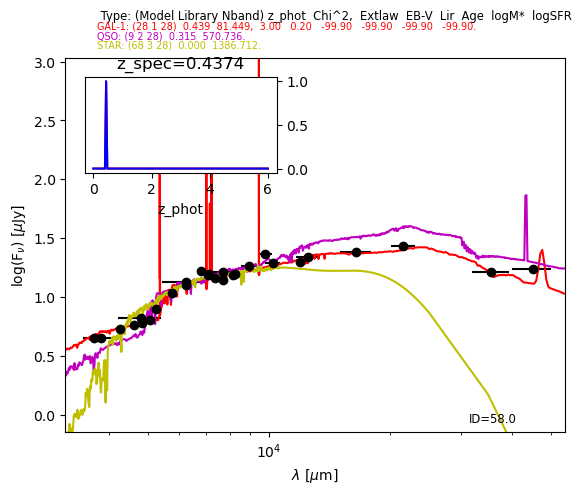

In [31]:
##############  PLOT  ############### FROM SPEC.PY

### Initialise the figure
fig = plt.figure()

### Main panel
ax1 = fig.add_axes(
    [0.1, 0.1, 0.78, 0.78], xscale="log", xlabel="$\lambda$ [$\mu$m]", ylabel="log(F$_{\\nu}$) [$\mu$Jy]"
)

# only the reliable obs mag will be plotted:
em = em * 2.0
dlf = dlf / 2.0
mag1 = mag[(mag > 0.0) & (mag < 35) & (em > -3)]
em1 = em[(mag > 0.0) & (mag < 35) & (em > -3)]
lf1 = lf[(mag > 0.0) & (mag < 35) & (em > -3)] / 10000.0
dlf1 = dlf[(mag > 0.0) & (mag < 35) & (em > -3)] / 10000.0

if len(mag1 > 0):
    ymin = max(mag1 + 2.0)
    ymax = min(mag1 - 4.0)
else:
    ymin = 10
    ymax = 20
if ymin > 60:
    ymin = 30

ic = (em1 >= 0.0) & (em1 < 2.0)
lf2 = lf1[ic]
mag2 = -0.4 * (mag1[ic] - 23.91)
em2 = 0.4 * em1[ic]
dlf2 = dlf1[ic]
# low S/N bands:
ic2 = (em1 >= 2.0) & (em1 < 8.0)
lf2b = lf1[ic2]
mag2b = -0.4 * (mag1[ic2] - 23.91)
em2b = 0.4 * em1[ic2]
dlf2b = dlf1[ic2]

print(em)
# set the plot aspect
if len(lf1 > 0):
    ax1.axis([min(lf1) * 0.85, max(lf1) * 1.2, -0.4 * (ymin - 23.91), -0.4 * (ymax - 23.91)])
else:
    ax1.axis([0, 100000, -0.4 * (ymin - 23.91), -0.4 * (ymax - 23.91)])
### plot SED and print info of best-fit models
col_lst = ["r", "g", "b", "m", "y"]  # each one with a different color
plt.figtext(
    0.15,
    0.96,
    " Type: (Model Library Nband) z_phot  Chi^2,  Extlaw  EB-V  Lir  Age  logM*  logSFR",
    size="small",
)
plt.figtext(0.73, 0.12, "ID=" + id, size="small")
iml = 0
for im in range(len(models_info)):
    if int(models_info[im][2]) == -1:
        continue  # print only models really used
    iml = iml + 1  # counter of models used
    ax1.plot(lg[im], mg[im], color=col_lst[im])  # plot the SED
    del models_info[im][6:8]  # do not print z_inf and z_sup
    del models_info[im][-1]  # nor sSFR
    info1 = ("  ".join(["%.3f"] * len(models_info[im][5:7]))) % tuple(
        [float(j) for j in models_info[im][5:7]]
    )
    if float(models_info[im][8]) >= 0.0:  # additional information
        info2 = ("   ".join(["%.2f"] * len(models_info[im][8:]))) % tuple(
            [float(j) for j in models_info[im][8:]]
        )
        info2 = ",  " + info2 + "."
    else:
        info2 = "."
    infol = models_info[im][0] + ": (" + " ".join(models_info[im][2:5]) + ")  " + info1 + info2
    plt.figtext(0.15, 0.96 - 0.02 * iml, infol, color=col_lst[im], size="x-small")  # print the rest

# plot the obs mag...
ax1.errorbar(lf2b, mag2b, yerr=em2b, xerr=dlf2b, fmt="o", color="0.6")
ax1.errorbar(lf2, mag2, yerr=em2, xerr=dlf2, fmt="o", color="0.")
# ... and upper limits
iu = np.where(em1 < 0)
if len(iu[0]) > 0:
    lf3 = lf1[iu]
    mag3 = -0.4 * (mag1[iu] - 23.91)
    ax1.quiver(lf3, mag3, 0, -1, units="height", width=0.004, headwidth=5, color="k", pivot="tip")

### 2nd panel (inset) showing PDF(z)
base = 0.9 - 0.02 * iml  # starting position for the inset plot
if base > 0.84:
    base = 0.84
ax2 = fig.add_axes([0.13, base - 0.20, 0.3, 0.20], xlabel="z_phot", title="z_spec=" + zspec)
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")
ax2.plot(zpdf[0, :], zpdf[1, :] / max(zpdf[1, :]), color="r")
ax2.plot(zpdf[0, :], zpdf[2, :] / max(zpdf[2, :]), color="b")
# plot also z_phot with error bar
# ax2.errorbar(zphot,0.5,fmt='ok',xerr=[[zphot-z68low],[z68hig-zphot]],mfc='none')

/tmp/ipykernel_4071833/940472326.py:14: RuntimeWarning: divide by zero encountered in log
  ax2.plot(zarr, -2*np.log(zgmin), color=color)


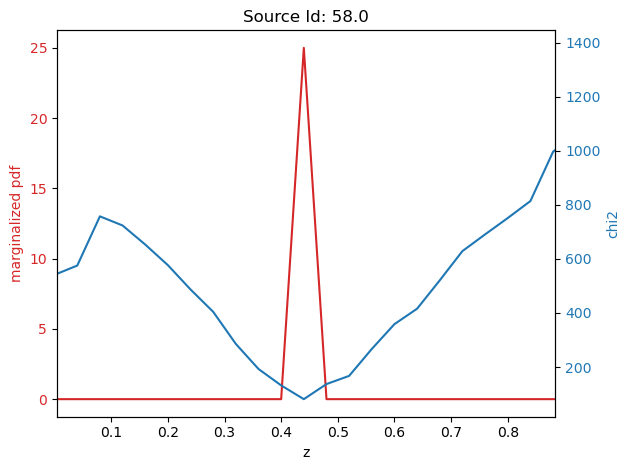

In [32]:
zarr = src.pdfmap[11].xaxis
zgmin = src.pdfmap[maptype["MIN_ZG"]].vPDF
zgbay = src.pdfmap[maptype["BAY_ZG"]].vPDF
fig, ax1 = plt.subplots()
ax1.set_title("Source Id: " + src.spec)
color = "tab:red"
ax1.set_xlabel("z")
ax1.set_ylabel("marginalized pdf", color=color)
plt.plot(zarr, zgbay, color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("chi2", color=color)  # we already handled the x-label with ax1
ax2.plot(zarr, -2 * np.log(zgmin), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_xlim(src.zgmin[0] - src.zgmin[5], src.zgmin[0] + src.zgmin[6])
fig.tight_layout()

(0.0, 2000.0)

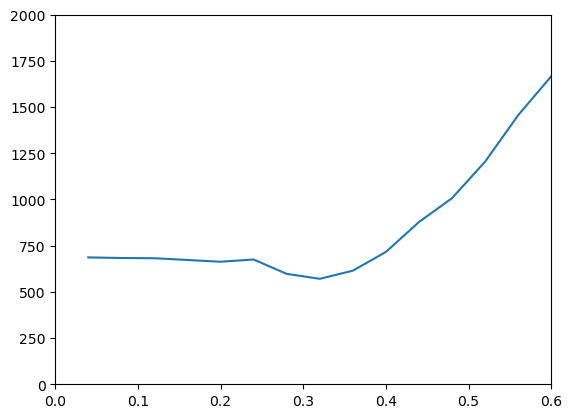

In [33]:
mask = np.array(src.pdfmap[10].chi2) < 1.0e9
plt.plot(np.array(zarr)[mask], np.array(src.pdfmap[10].chi2)[mask])
plt.xlim(0.0, 0.6)
plt.ylim(0, 2000)